# Qubit characterization tests

In [1]:
import qiskit.pulse as pulse
import qiskit.circuit as circuit
from qiskit.providers.tergite import Tergite
import template_schedules as templates
from quantify_core.analysis import fitting_models as fm
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
import numpy as np
import re
import matplotlib.pyplot as plt
from quantify_core.visualization import mpl_plotting as qpl
import matplotlib.ticker as plticker
from tempfile import gettempdir
import tqcsf.file
from analysis.spectroscopy_analysis import LorentzianModel
from scipy.spatial import distance_matrix
import time
import requests
import pathlib
import functools
from inspect import getsource
import rich
def format_fit_data(model, x, s21, ds, fit_result, /, **kwargs):
    abs_s21 = np.abs(s21)
    return {
        "job_id" : ds.attrs["job_id"],
        "tuid" : ds.attrs["tuid"],
        "model": model.name,
        "Average |s21|" : {"value": float(abs_s21.mean()) },
        "Minimum |s21|" : {"value": float(abs_s21.min()) },
        "Maximum |s21|" : {"value": float(abs_s21.max()) },
        "Arg Minimum |s21|" : {"value": float(x[np.argmin(abs_s21)]) },
        "Arg Maximum |s21|" : {"value": float(x[np.argmax(abs_s21)]) },
    } | {
        p : {
            "value" : v.value,
            "stderr" : v.stderr
        } for p, v in fit_result.params.items()
    } | kwargs

def plot_fit_resonator(ds):
    
    fig, axs = plt.subplots(len(ds), 1)
    if len(ds) == 1:
        axs = [axs]

    f = list()
        
    for i,var in enumerate(ds):
        # plot data
        np.abs(ds[var]).plot(ax = axs[i])
        axs[i].set_title(var)

        # retrieve raw data for model fitting
        x = ds.coords[ds.variables[var].attrs["coords"][0]].data
        s21 = ds[var].data

        # fit resonator model against the data
        model = fm.ResonatorModel()
        guess = model.guess(s21, f = x)
        fit_result = model.fit(s21, params = guess, f = x)
        
        axs[i].axvline(fit_result.params["fr"].value, ls="--", color = "black", alpha = 0.2)
        axs[i].axvline(x[np.argmin(np.abs(s21))], ls="-", color = "red")

        # plot model fit
        qpl.plot_fit(
            ax=axs[i],
            fit_res=fit_result,
            plot_init=True,
            range_casting="abs",
        )
        f.append(format_fit_data(model, x, s21, ds, fit_result, code = "RESONATOR_SPEC"))
    
    return f

def plot_fit_lorentz(ds):
    fig, axs = plt.subplots(len(ds), 1)
    if len(ds) == 1:
        axs = [axs]
    
    f = list()
    for i,var in enumerate(ds):
        # plot data
        np.abs(ds[var]).plot(ax = axs[i])
        axs[i].set_title(var)

        # retrieve raw data for model fitting
        x = ds.coords[ds.variables[var].attrs["coords"][0]].data
        s21 = ds[var].data

        # fit resonator model against the data
        model = LorentzianModel()
        guess = model.guess(np.abs(s21), x = x)
        fit_result = model.fit(np.abs(s21), params = guess, x = x)

        model_y = fit_result.eval(x = x)
        axs[i].plot(x, model_y,'r-')
        print()
        print(var,":", fit_result.params["x0"].value/1e9, "GHz")
        f.append(format_fit_data(model, x, s21, ds, fit_result, code = "QUBIT_SPEC"))
        
    return f

def plot_fit_cosine(ds):
    fig, axs = plt.subplots(len(ds), 1)
    if len(ds) == 1:
        axs = [axs]
    
    f = list()
    for i,var in enumerate(ds):
        # plot data
        np.abs(ds[var]).plot(ax = axs[i])
        axs[i].set_title(var)

        # retrieve raw data for model fitting
        x = ds.coords[ds.variables[var].attrs["coords"][0]].data
        s21 = ds[var].data

        # fit resonator model against the data
        model = fm.CosineModel()
        guess = model.guess(np.abs(s21), x = x)
        fit_result = model.fit(np.abs(s21), params = guess, x = x)

        model_y = fit_result.eval(x = x)
        axs[i].plot(x, model_y,'r-')
        
        idxs = np.argmax(model_y)
        v = x[idxs]
        axs[i].axvline(v, color = "red")
        print(var,":", v*1000, "mV")
        f.append(format_fit_data(model, x, s21, ds, fit_result, code = "RABI_OSC", ket1_amp = v))
        
    return f

def plot_fit_decay(ds):
    fig, axs = plt.subplots(len(ds), 1)
    if len(ds) == 1:
        axs = [axs]
    
    f = list()
    for i,var in enumerate(ds):
        # plot data
        np.abs(ds[var]).plot(ax = axs[i])
        axs[i].set_title(var)

        # retrieve raw data for model fitting
        x = ds.coords[ds.variables[var].attrs["coords"][0]].data
        s21 = ds[var].data

        # fit resonator model against the data
        model = fm.ExpDecayModel()
        guess = model.guess(np.abs(s21), delay = x)
        fit_result = model.fit(np.abs(s21), params = guess, t = x)

        model_y = fit_result.eval(delay = x)
        axs[i].plot(x, model_y,'r-')
        print(var,":", fit_result.params["tau"].value, "ns")
        f.append(format_fit_data(model, x, s21, ds, fit_result, code = "T1_DECOHERENCE"))
        
    return f

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("PinguOpenPulse")
backend.set_options(shots = 1500)
templates.backend = backend

In [3]:
QUBIT = "q4"
QUBIT_IDX = int(QUBIT[1])-1

In [5]:
resonator_freqs = {
    "q1": 6.884461765134884e9,
    "q2": 6.745482508417368e9, 
    "q3": 7.029379073099976e9, 
    "q4": 7.187505069855161e9, 
    "q5": 6.660153814436366e9
}
VNA_qub_freqs = {
    'q1' : 5.8977e9, 
    'q2' : 6.109e9,  # I think this is the wrong peak
    'q3' : 6.0940e9,
    'q4' : 5.9500e9, 
    'q3c4' :7.3632e9, 
    'q5' : 5.0341e9  # has weird discontinuities?
}

# Resonator spec

In [6]:
frequencies = np.linspace(resonator_freqs[QUBIT] - 6e6, resonator_freqs[QUBIT] + 6e6, 160)

In [7]:
param_sched = pulse.ScheduleBlock(name = f"res spec {QUBIT}")

freq0 = circuit.Parameter(f"f readout 0")
param_sched += pulse.SetFrequency(freq0, backend.measure_channel(QUBIT_IDX))

ro_dur = 3000
ro_amp = 14e-3

param_sched += templates.measure(QUBIT_IDX, ro_amp = ro_amp, ro_dur = ro_dur)

In [8]:
sweep = [
    param_sched.assign_parameters(
        {
            freq0 : f,
        },
        inplace = False
    )
    for f in frequencies
]
print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 160


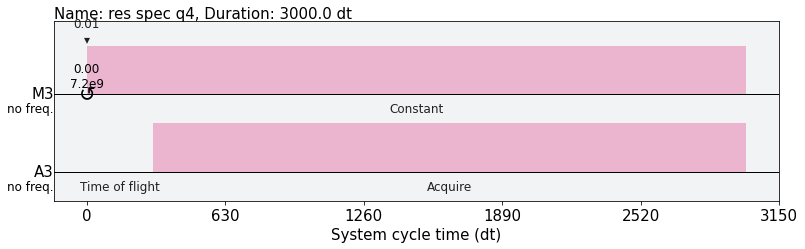

In [9]:
sweep[10].draw(style=IQXDebugging())

In [10]:
# compile metadata about the sweep
qobj_header = {
    "sweep" : {
        "serial_order" : ("frequencies",),
        "parameters" : {
            "frequencies": {
                "long_name" : "Frequency of readout pulse",
                "unit" : "Hz",
                "slots" : { QUBIT_IDX : frequencies }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header)

Tergite: Job has been successfully submitted


In [11]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")
ds = sf.as_xarray()
ds

20220831-172148-213-502883:   0%|          | 0/160 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (frequencies/slot~3: 160)
Coordinates:
  * frequencies/slot~3  (frequencies/slot~3) float64 7.182e+09 ... 7.194e+09
Data variables:
    slot~3/acq~0        (frequencies/slot~3) complex128 (-0.00286013159878654...
Attributes:
    job_id:            6a0ec009-f58f-476a-843f-984ca0e8cdc1
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220831-172148-213-502883

[
    {
        'job_id': '6a0ec009-f58f-476a-843f-984ca0e8cdc1',
        'tuid': '20220831-172148-213-502883',
        'model': 'Model(hanger_func_complex_SI)',
        'Average |s21|': {'value': 0.0025942042011677267},
        'Minimum |s21|': {'value': 0.0012919913687680562},
        'Maximum |s21|': {'value': 0.003082324606610984},
        'Arg Minimum |s21|': {'value': 7187391862.307991},
        'Arg Maximum |s21|': {'value': 7190561673.628746},
        'fr': {'value': 7187534831.598946, 'stderr': 23996.84072669391},
        'Ql': {'value': 21758.07390886608, 'stderr': 3161.0384437479356},
        'Qe': {'value': 41547.49976340035, 'stderr': 4449.461783166036},
        'A': {'value': 0.0026188253582439813, 'stderr': 2.0434152119172037e-05},
        'theta': {'value': -0.7064553839484912, 'stderr': 0.10709068625098463},
        'phi_v': {'value': -1.3382475323542199e-06, 'stderr': 2.251957895383444e-09},
        'phi_0': {'value': 9607.477541930028, 'stderr': 16.186078577053625},
        'alpha': {'value': -0.6774936518631474, 'stderr': 16.18602668000255},
        'Qi': {'value': 36164.31726190743, 'stderr': 7346.205375301402},
        'Qc': {'value': 54619.783142990236, 'stderr': 7689.856688376321},
        'code': 'RESONATOR_SPEC',
        'ro_amp': 0.014,
        'ro_dur': 3e-06,
        'qubit': 'q4'
    }
]

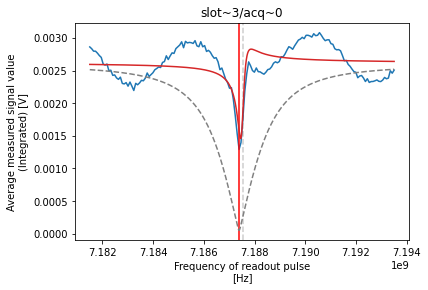

In [12]:
%matplotlib inline
data = plot_fit_resonator(ds)
data[0]["ro_amp"] = ro_amp
data[0]["ro_dur"] = ro_dur*1e-9
data[0]["qubit"] = QUBIT
rich.print(data)

In [13]:
job.store_data(data)

Store this data? (y/n)  y


# Qubit spectroscopy

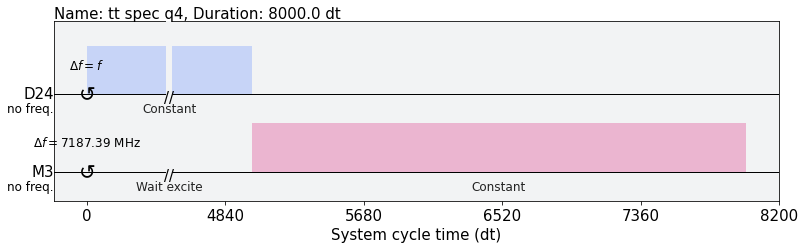

In [14]:
param_sched = pulse.ScheduleBlock(name = f"tt spec {QUBIT}")

param_sched += pulse.SetFrequency(res_fr:=7187391862.307991, backend.measure_channel(QUBIT_IDX))

freq = circuit.Parameter(f"f drive")
stim_dur = 5000

param_sched += pulse.SetFrequency(freq, backend.drive_channel(QUBIT_IDX))

param_sched += pulse.Play(pulse.Constant(
    stim_dur,
    amp = (stim_amp := 14e-3),
), backend.drive_channel(QUBIT_IDX))
# don't measure during excitation
param_sched += pulse.Delay(stim_dur, backend.measure_channel(QUBIT_IDX), name = "Wait excite")
param_sched += pulse.Delay(stim_dur, backend.acquire_channel(QUBIT_IDX), name = "Wait excite")

param_sched += templates.measure(QUBIT_IDX, ro_amp = ro_amp, ro_dur = ro_dur)
param_sched.draw()

In [15]:
GHz = 1e9
MHz = 1e6

center = VNA_qub_freqs[QUBIT]
freq_span = 60 *MHz
freq_step = 0.36 *MHz

frequencies = np.arange(center - freq_span/2, center + freq_span/2, freq_step)
print("That will be:", frequencies.shape[0], "schedules")

That will be: 167 schedules


In [16]:
sweep = [
    param_sched.assign_parameters(
        {
            freq : f,
        },
        inplace = False
    )
    for f in frequencies
]
print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 167


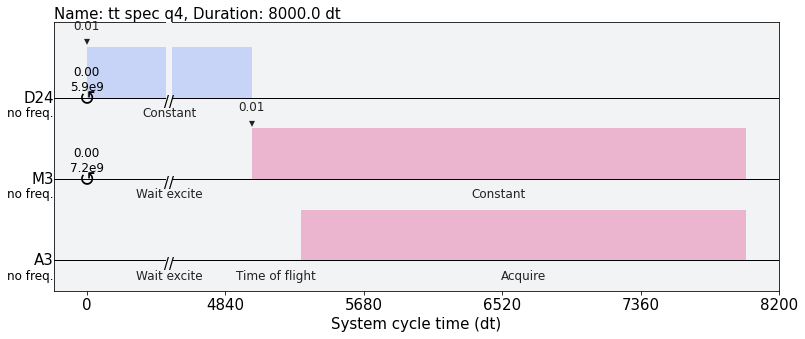

In [17]:
sweep[20].draw(style=IQXDebugging())

In [18]:
# compile metadata about the sweep
qobj_header = {
    "sweep" : {
        "serial_order" : ("frequencies",),
        "parameters" : {
            "frequencies": {
                "long_name" : "Frequency of drive pulse",
                "unit" : "Hz",
                "slots" : { QUBIT_IDX : frequencies }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header)

Tergite: Job has been successfully submitted


In [19]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")
print("File location: ", pathlib.Path(gettempdir()) / sf.job_id)
ds = sf.as_xarray()
ds

File location:  C:\Users\axean\AppData\Local\Temp\29c43b42-00ec-4f44-97b1-250035ca6868


20220831-172506-086-431037:   0%|          | 0/167 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (frequencies/slot~3: 167)
Coordinates:
  * frequencies/slot~3  (frequencies/slot~3) float64 5.92e+09 ... 5.98e+09
Data variables:
    slot~3/acq~0        (frequencies/slot~3) complex128 (-0.00026125989855675...
Attributes:
    job_id:            29c43b42-00ec-4f44-97b1-250035ca6868
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220831-172506-086-431037


slot~3/acq~0 : 5.950369506889603 GHz


[
    {
        'job_id': '29c43b42-00ec-4f44-97b1-250035ca6868',
        'tuid': '20220831-172506-086-431037',
        'model': 'Model(lorentzian)',
        'Average |s21|': {'value': 0.0014047562848719176},
        'Minimum |s21|': {'value': 0.0012375926300086716},
        'Maximum |s21|': {'value': 0.0022370092375316214},
        'Arg Minimum |s21|': {'value': 5968600000.0},
        'Arg Maximum |s21|': {'value': 5951680000.0},
        'x0': {'value': 5950369506.889604, 'stderr': 276187.7171269425},
        'width': {'value': 8122824.264947628, 'stderr': 907786.8671485909},
        'A': {'value': 4856.344126753926, 'stderr': 489.5966147774399},
        'c': {'value': 0.0012753750117749506, 'stderr': 1.4725703112138175e-05},
        'code': 'QUBIT_SPEC',
        'ro_amp': 0.014,
        'ro_dur': 3e-06,
        'stim_dur': 5e-06,
        'stim_amp': 0.014,
        'qubit': 'q4',
        'res_fr': 7187391862.307991
    }
]

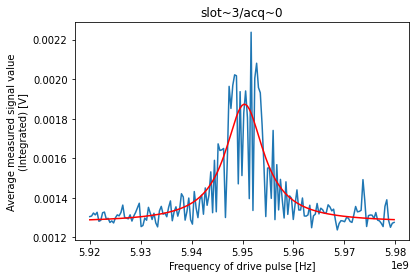

In [20]:
data = plot_fit_lorentz(ds)
data[0]["ro_amp"] = ro_amp
data[0]["ro_dur"] = ro_dur*1e-9
data[0]["stim_dur"] = stim_dur*1e-9
data[0]["stim_amp"] = stim_amp
data[0]["qubit"] = QUBIT
data[0]["res_fr"] = res_fr
rich.print(data)

In [21]:
job.store_data(data)

Store this data? (y/n)  y


# Rabi oscillation

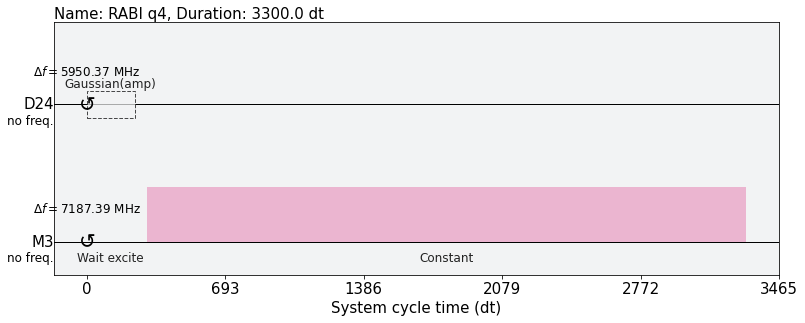

In [22]:
param_sched = pulse.ScheduleBlock(name = f"RABI {QUBIT}")

param_sched += pulse.SetFrequency(res_fr, backend.measure_channel(QUBIT_IDX))
param_sched += pulse.SetFrequency(stim_fr:=5950369506.889604, backend.drive_channel(QUBIT_IDX))

amp = circuit.Parameter(f"amp drive")
stim_dur = 240

param_sched += pulse.Play(pulse.Gaussian(
    stim_dur,
    amp = amp,
    sigma=round(stim_dur/5)
), backend.drive_channel(QUBIT_IDX))
# don't measure during excitation
param_sched += pulse.Delay(stim_dur, backend.measure_channel(QUBIT_IDX), name = "Wait excite")
param_sched += pulse.Delay(stim_dur, backend.acquire_channel(QUBIT_IDX), name = "Wait excite")

param_sched += templates.measure(QUBIT_IDX, ro_amp = ro_amp, ro_dur = ro_dur)
param_sched.draw()

In [23]:
amplitudes = np.linspace(0.01e-3, 20e-3, 100)
print("That will be:", amplitudes.shape[0], "schedules")

That will be: 100 schedules


In [24]:
%matplotlib inline
sweep = [
    param_sched.assign_parameters(
        {
            amp : a
        },
        inplace = False
    )
    for a in amplitudes
]
print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 100


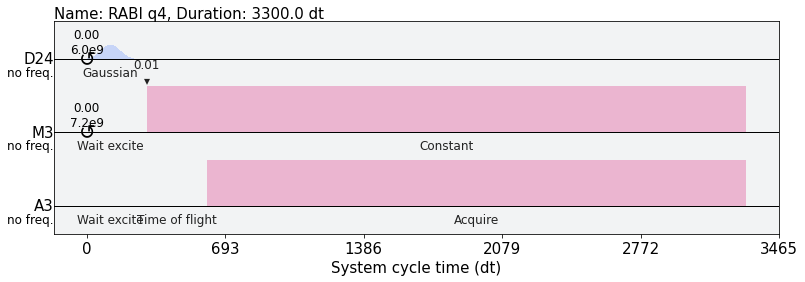

In [25]:
sweep[15].draw(style=IQXDebugging())

In [26]:
# compile metadata about the sweep
qobj_header = {
    "sweep" : {
        "serial_order" : ("amplitudes",),
        "parameters" : {
            "amplitudes": {
                "long_name" : "amplitude of drive pulse",
                "unit" : "V",
                "slots" : { QUBIT_IDX : amplitudes }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header)

Tergite: Job has been successfully submitted


In [28]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")
print("File location: ", pathlib.Path(gettempdir()) / sf.job_id)
ds = sf.as_xarray()
ds

File location:  C:\Users\axean\AppData\Local\Temp\42cafb36-f75d-4272-bf5f-2f3cf059defa


20220831-172851-687-2a337e:   0%|          | 0/100 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:            (amplitudes/slot~3: 100)
Coordinates:
  * amplitudes/slot~3  (amplitudes/slot~3) float64 1e-05 0.0002119 ... 0.02
Data variables:
    slot~3/acq~0       (amplitudes/slot~3) complex128 (-0.0002300329901632621...
Attributes:
    job_id:            42cafb36-f75d-4272-bf5f-2f3cf059defa
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220831-172851-687-2a337e

slot~3/acq~0 : 15.759696969696972 mV


[
    {
        'job_id': '42cafb36-f75d-4272-bf5f-2f3cf059defa',
        'tuid': '20220831-172851-687-2a337e',
        'model': 'Model(cos_func)',
        'Average |s21|': {'value': 0.001967086446163622},
        'Minimum |s21|': {'value': 0.0012530189530362641},
        'Maximum |s21|': {'value': 0.002514205212029775},
        'Arg Minimum |s21|': {'value': 0.0010195959595959596},
        'Arg Maximum |s21|': {'value': 0.01656737373737374},
        'frequency': {'value': 32.043938773384646, 'stderr': 0.46132086701697494},
        'amplitude': {'value': 0.0005805327858134923, 'stderr': 5.5436447900736264e-06},
        'offset': {'value': 0.00186366365638143, 'stderr': 6.6622525431489415e-06},
        'phase': {'value': 3.1144257720252533, 'stderr': 0.03718720078953545},
        'code': 'RABI_OSC',
        'ket1_amp': 0.015759696969696972,
        'ro_amp': 0.014,
        'ro_dur': 3e-06,
        'stim_dur': 2.4000000000000003e-07,
        'qubit': 'q4',
        'res_fr': 7187391862.307991,
        'stim_fr': 5950369506.889604,
        'stim_sigma': 4.8000000000000006e-08
    }
]

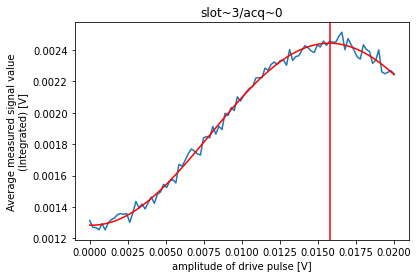

In [29]:
data = plot_fit_cosine(ds)
data[0]["ro_amp"] = ro_amp
data[0]["ro_dur"] = ro_dur*1e-9
data[0]["stim_dur"] = stim_dur*1e-9
data[0]["qubit"] = QUBIT
data[0]["res_fr"] = res_fr
data[0]["stim_fr"] = stim_fr
data[0]["stim_sigma"] = round(stim_dur/5)*1e-9
rich.print(data)

In [30]:
job.store_data(data)

Store this data? (y/n)  y


# Decoherence measurement (T1)

In [33]:
param_sched = pulse.ScheduleBlock(name = f"T1 {QUBIT}")

param_sched += pulse.SetFrequency(res_fr, backend.measure_channel(QUBIT_IDX))
param_sched += pulse.SetFrequency(stim_fr, backend.drive_channel(QUBIT_IDX))

t1_wait = circuit.Parameter(f"t1 wait")
stim_amp = 0.015759696969696972

param_sched += pulse.Play(pulse.Gaussian(
    stim_dur,
    amp = stim_amp,
    sigma=round(stim_dur/5)
), backend.drive_channel(QUBIT_IDX))
# don't measure during excitation
param_sched += pulse.Delay(stim_dur, backend.measure_channel(QUBIT_IDX), name = "Wait excite")
param_sched += pulse.Delay(stim_dur, backend.acquire_channel(QUBIT_IDX), name = "Wait excite")

param_sched += pulse.Delay(t1_wait, backend.measure_channel(QUBIT_IDX), name = "T1 Wait")
param_sched += pulse.Delay(t1_wait, backend.acquire_channel(QUBIT_IDX), name = "T1 Wait")

param_sched += templates.measure(QUBIT_IDX, ro_amp = ro_amp, ro_dur = ro_dur)

In [34]:
durations = np.arange(4, 65000, 412)
print("That will be:", durations.shape[0], "schedules")

That will be: 158 schedules


In [35]:
%matplotlib inline
sweep = [
    param_sched.assign_parameters(
        {
            t1_wait : d
        },
        inplace = False
    )
    for d in durations
]
print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 158


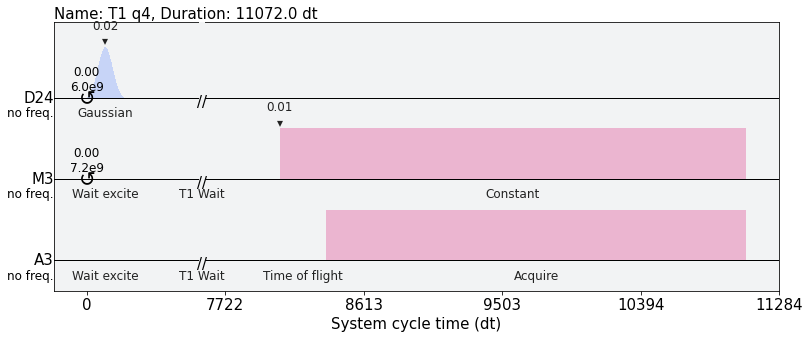

In [36]:
sweep[19].draw(style=IQXDebugging())

In [37]:
# compile metadata about the sweep
qobj_header = {
    "sweep" : {
        "serial_order" : ("durations",),
        "parameters" : {
            "durations": {
                "long_name" : "t1 wait duration",
                "unit" : "ns",
                "slots" : { QUBIT_IDX : durations }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header)

Tergite: Job has been successfully submitted


In [38]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")
print("File location: ", pathlib.Path(gettempdir()) / sf.job_id)
ds = sf.as_xarray()
ds

File location:  C:\Users\axean\AppData\Local\Temp\872d339a-7011-403e-8851-435232bb3034


20220831-173127-255-b62fc7:   0%|          | 0/158 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:           (durations/slot~3: 158)
Coordinates:
  * durations/slot~3  (durations/slot~3) int32 4 416 828 ... 63864 64276 64688
Data variables:
    slot~3/acq~0      (durations/slot~3) complex128 (-0.00046130742369140026+...
Attributes:
    job_id:            872d339a-7011-403e-8851-435232bb3034
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220831-173127-255-b62fc7

slot~3/acq~0 : 38838.64883077471 ns


[
    {
        'job_id': '872d339a-7011-403e-8851-435232bb3034',
        'tuid': '20220831-173127-255-b62fc7',
        'model': 'Model(exp_decay_func)',
        'Average |s21|': {'value': 0.0018017912351377533},
        'Minimum |s21|': {'value': 0.0013444378000902896},
        'Maximum |s21|': {'value': 0.002471549599903226},
        'Arg Minimum |s21|': {'value': 52740.0},
        'Arg Maximum |s21|': {'value': 4.0},
        'tau': {'value': 38838.64883077471, 'stderr': 2245.0999732618648},
        'amplitude': {'value': 0.0013647853411390969, 'stderr': 3.177796668406951e-05},
        'offset': {'value': 0.0011364214803633906, 'stderr': 3.780529637948237e-05},
        'n_factor': {'value': 1, 'stderr': 0.0},
        'code': 'T1_DECOHERENCE',
        'ro_amp': 0.014,
        'ro_dur': 3e-06,
        'stim_dur': 2.4000000000000003e-07,
        'qubit': 'q4',
        'res_fr': 7187391862.307991,
        'stim_fr': 5950369506.889604,
        'stim_sigma': 4.8000000000000006e-08,
        'stim_amp': 0.015759696969696972
    }
]

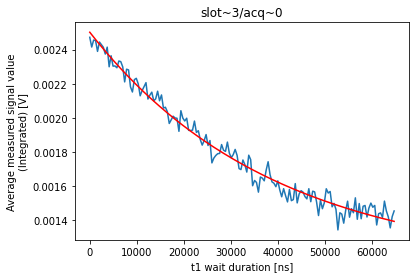

In [39]:
data = plot_fit_decay(ds)
data[0]["ro_amp"] = ro_amp
data[0]["ro_dur"] = ro_dur*1e-9
data[0]["stim_dur"] = stim_dur*1e-9
data[0]["qubit"] = QUBIT
data[0]["res_fr"] = res_fr
data[0]["stim_fr"] = stim_fr
data[0]["stim_sigma"] = round(stim_dur/5)*1e-9
data[0]["stim_amp"] = stim_amp
rich.print(data)

In [40]:
job.store_data(data)

Store this data? (y/n)  y


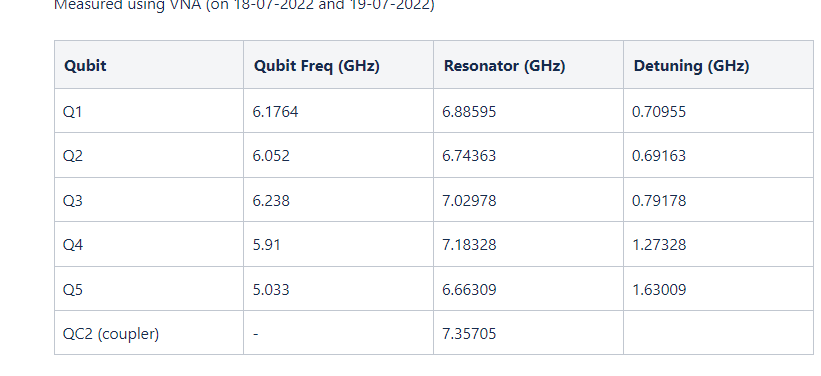